In [3]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
from utils import detectAirportRunway, computeHoughTransformCoord

path = "AirportRunway618"
images = []
labels = []
nums = range(300, 560)

for i in nums:
    image_path = "AirportRunway618/Camera1_" + str(i) + ".jpg"
    images.append(image_path)

    label_path = "AirportRunway618/Camera1_" + str(i) + ".json"
    labels.append(label_path)

rho0ErrorList = []
rho1ErrorList = []
theta0ErrorList = []
theta1ErrorList = []

for i in range(len(images)):

    image = cv2.imread(images[i])
    if image is None:
        print(f"image not found, path {images[i]}")
    height, width, _ = image.shape

    uv = np.ones([4, 2])
    with open(labels[i], "r") as f:
        label = json.load(f)
        uv[0] = label["RunwayVertexCoord"]["Coord1"]["UVCoord"] 
        uv[1] = label["RunwayVertexCoord"]["Coord2"]["UVCoord"]
        uv[2] = label["RunwayVertexCoord"]["Coord3"]["UVCoord"]
        uv[3] = label["RunwayVertexCoord"]["Coord4"]["UVCoord"]

    # calculate runway boundary and rescale
    r = 0.3 # scale factor
    xmax = max(uv[:,0]) 
    xmin = min(uv[:,0])
    ymax = max(uv[:,1])
    ymin = min(uv[:,1])
    xlen = xmax - xmin
    ylen = ymax - ymin
    Bxmin = max(xmin - xlen * r, 0)
    Bxmax = min(xmax + xlen * r, width)
    Bymin = max(ymin - ylen * r, 0)
    Bymax = min(ymax + ylen * r, height)
    cv2.imwrite("origin/" + str(nums[i]) + ".jpg", image[int(Bymin):int(Bymax), int(Bxmin):int(Bxmax)])

    # convert coord origin to the center of image
    uv[:,0] -= width/2
    uv[:,1] -= height/2

    # ground truth
    theta0, rho0, _ = computeHoughTransformCoord(uv[0,0], uv[0,1], uv[1,0], uv[1,1])
    theta1, rho1, _ = computeHoughTransformCoord(uv[2,0], uv[2,1], uv[3,0], uv[3,1])

    line0, line1 = detectAirportRunway(image[int(Bymin):int(Bymax), int(Bxmin):int(Bxmax)], draw=True, res_name=str(nums[i]))
    if abs(line0[0] - theta0) < abs(line0[0] - theta1):
        theta0_, rho0_ = line0
        theta1_, rho1_ = line1
    else:
        theta0_, rho0_ = line1
        theta1_, rho1_ = line0
    
    rho0_ += int(Bxmin-int(width)/2)*np.cos(theta0_) + int(Bymin-int(height/2))*np.sin(theta0_)
    rho1_ += int(Bxmin-int(width)/2)*np.cos(theta1_) + int(Bymin-int(height/2))*np.sin(theta1_)
    
    theta0ErrorList.append(theta0_-theta0)
    theta1ErrorList.append(theta1_-theta1)

    rho0ErrorList.append(rho0_-rho0)
    rho0ErrorList.append(rho1_-rho1)

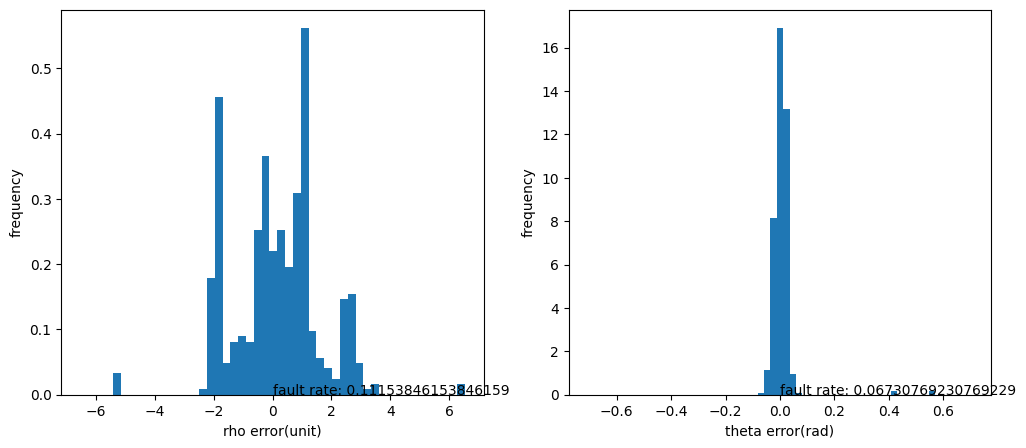

In [4]:
rhoErrorList = rho0ErrorList + rho1ErrorList
rhoErrorListM = [x for x in rhoErrorList if abs(x)<20]
thetaErrorList = theta0ErrorList + theta1ErrorList
thetaErrorListM = [x for x in thetaErrorList if abs(x)<1]

plt.figure(figsize=[12, 5])
plt.subplot(1,2,1)
plt.hist(rhoErrorListM, bins=80, density=True)
plt.xlabel("rho error(unit)")
plt.ylabel("frequency")
plt.xlim([-4*np.std(rhoErrorListM), 4*np.std(rhoErrorListM)])
plt.text(0, 0, f"fault rate: {1 - len(rhoErrorListM)/len(rhoErrorList)}")

plt.subplot(1,2,2)
plt.hist(thetaErrorListM, bins=80, density=True)
plt.xlabel("theta error(rad)")
plt.ylabel("frequency")
plt.xlim([-4*np.std(thetaErrorListM), 4*np.std(thetaErrorListM)])
plt.text(0, 0, f"fault rate: {1 - len(thetaErrorListM)/len(thetaErrorList)}")
plt.show()